In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d, Dropout, Sequential, ReLU
from torch_geometric.nn import NNConv, GCNConv, global_mean_pool, global_max_pool, global_add_pool
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MoleculeNet
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# --- Device Selection ---
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    print("Using CUDA GPU")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("Using APPLE MPS")
else:
    DEVICE = torch.device("cpu")
    print("Using CPU")


NUM_GRAPHS_PER_BATCH = 32
LEARNING_RATE = 0.001
EPOCHS = 150
K_FOLDS = 5 
EARLY_STOP_PATIENCE = 30


dataset = MoleculeNet(".", name="FreeSolv")

# Shuffle dataset once
torch.manual_seed(1011)
dataset = dataset.shuffle()

print(f"Total dataset size: {len(dataset)}")
print(f"Using {K_FOLDS}-fold cross-validation")
print(f"Using device: {DEVICE}")


class MolecularGCN_EdgeNet(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, embedding_dim=64, dropout=0.1):
        super(MolecularGCN_EdgeNet, self).__init__()
        self.embedding_dim = embedding_dim
        self.node_encoder = Linear(num_node_features, embedding_dim)

        # --- Edge-conditioned NNConv layers ---
        edge_nn1 = Sequential(
            Linear(num_edge_features, embedding_dim // 2),
            ReLU(),
            Dropout(dropout),
            Linear(embedding_dim // 2, embedding_dim * embedding_dim)
        )
        self.edge_conv1 = NNConv(embedding_dim, embedding_dim, edge_nn1, aggr="mean")
        self.bn_edge1 = BatchNorm1d(embedding_dim)

        edge_nn2 = Sequential(
            Linear(num_edge_features, embedding_dim // 2),
            ReLU(),
            Dropout(dropout),
            Linear(embedding_dim // 2, embedding_dim * embedding_dim)
        )
        self.edge_conv2 = NNConv(embedding_dim, embedding_dim, edge_nn2, aggr="mean")
        self.bn_edge2 = BatchNorm1d(embedding_dim)

        # --- Standard GCN layers ---
        self.conv1 = GCNConv(embedding_dim, embedding_dim)
        self.bn_conv1 = BatchNorm1d(embedding_dim)
        self.conv2 = GCNConv(embedding_dim, embedding_dim)
        self.bn_conv2 = BatchNorm1d(embedding_dim)

        self.dropout = Dropout(dropout)

        # --- Final MLP ---
        pool_dim = embedding_dim * 3  # mean + max + sum pooling
        self.fc1 = Linear(pool_dim, embedding_dim * 3)
        self.fc_bn = BatchNorm1d(embedding_dim * 3)
        self.fc2 = Linear(embedding_dim * 3, embedding_dim)
        self.out = Linear(embedding_dim, 1)

    def forward(self, x, edge_index, batch_index, edge_attr):
        edge_attr = (edge_attr - edge_attr.mean(dim=0)) / (edge_attr.std(dim=0) + 1e-6)
        x = F.relu(self.node_encoder(x))

        # Edge-Aware Message Passing
        x_res = x
        x = self.edge_conv1(x, edge_index, edge_attr)
        x = self.bn_edge1(x)
        x = F.relu(x)
        x = x + x_res
        x = self.dropout(x)

        x_res = x
        x = self.edge_conv2(x, edge_index, edge_attr)
        x = self.bn_edge2(x)
        x = F.relu(x)
        x = x + x_res

        # Standard Graph Convolutions
        x_res = x
        x = self.conv1(x, edge_index)
        x = self.bn_conv1(x)
        x = F.relu(x)
        x = x + x_res
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.bn_conv2(x)
        x = F.relu(x)

        # Multi-scale Global Pooling
        x_mean = global_mean_pool(x, batch_index)
        x_max = global_max_pool(x, batch_index)
        x_sum = global_add_pool(x, batch_index)
        x = torch.cat([x_mean, x_max, x_sum], dim=1)

        # Prediction Head
        x = F.relu(self.fc_bn(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        out = self.out(x)
        return out, x



def evaluate(model, loader):
    model.eval()
    total_loss = 0
    loss_fn = torch.nn.MSELoss()
    
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(DEVICE)
            pred, _ = model(batch.x.float(), batch.edge_index, batch.batch, batch.edge_attr.float())
            loss = loss_fn(pred, batch.y.view(-1, 1).float())
            total_loss += loss.item() * batch.num_graphs
    
    return total_loss / len(loader.dataset)


def train_one_fold(model, train_loader, val_loader, fold_num):
    model.to(DEVICE)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=0.5,
        patience=15,
        min_lr=1e-6,
    )
    loss_fn = torch.nn.MSELoss()
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    print(f"\n{'='*60}")
    print(f"Training Fold {fold_num}/{K_FOLDS}")
    print(f"{'='*60}")
    
    for epoch in range(EPOCHS):
        # Training
        model.train()
        epoch_loss = 0
        
        for batch in train_loader:
            batch = batch.to(DEVICE)
            optimizer.zero_grad()

            pred, _ = model(batch.x.float(), batch.edge_index, batch.batch, batch.edge_attr.float())
            loss = loss_fn(pred, batch.y.view(-1, 1).float())
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
     
        val_loss = evaluate(model, val_loader)
        val_losses.append(val_loss)
        
        scheduler.step(val_loss)
        
    
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f'best_model_fs_fold{fold_num}.pt')
        else:
            patience_counter += 1

        if epoch % 20 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch:4d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {current_lr:.6f}")
        
        # Early stopping
        if patience_counter >= EARLY_STOP_PATIENCE:
            print(f"\n️ Early stopping at epoch {epoch}")
            print(f"Best validation loss: {best_val_loss:.4f}")
            break

    # Load best model
    model.load_state_dict(torch.load(f'best_model_fs_fold{fold_num}.pt'))
    final_val_loss = evaluate(model, val_loader)
    
    return model, train_losses, val_losses, final_val_loss



def run_kfold_cv():
    num_node_features = dataset.num_node_features
    num_edge_features = dataset.num_edge_features
    
    print(f"Node features: {num_node_features}, Edge features: {num_edge_features}")
    
    # Calculate fold sizes
    dataset_size = len(dataset)
    fold_size = dataset_size // K_FOLDS
    
    fold_results = []
    all_fold_losses = []
    
    for fold in range(K_FOLDS):
  
        val_start = fold * fold_size
        val_end = val_start + fold_size if fold < K_FOLDS - 1 else dataset_size
        
   
        val_indices = list(range(val_start, val_end))
        train_indices = list(range(0, val_start)) + list(range(val_end, dataset_size))
        
        train_dataset = dataset[train_indices]
        val_dataset = dataset[val_indices]
        
        print(f"\nFold {fold+1}: Train={len(train_dataset)}, Val={len(val_dataset)}")
        
   
        train_loader = DataLoader(train_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True, drop_last=True)
        val_loader = DataLoader(val_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)
        
      
        model = MolecularGCN_EdgeNet(
            num_node_features=num_node_features,
            num_edge_features=num_edge_features
        )
        
  
        model, train_losses, val_losses, final_val_loss = train_one_fold(
            model, train_loader, val_loader, fold+1
        )
        
        fold_results.append({
            'fold': fold + 1,
            'val_loss': final_val_loss,
            'val_rmse': np.sqrt(final_val_loss),
            'train_losses': train_losses,
            'val_losses': val_losses
        })
        all_fold_losses.append(final_val_loss)
    
    # Print summary
    print("\n" + "="*60)
    print("K-FOLD CROSS-VALIDATION RESULTS")
    print("="*60)
    
    for result in fold_results:
        print(f"Fold {result['fold']}: Val Loss = {result['val_loss']:.4f}, Val RMSE = {result['val_rmse']:.4f}")
    
    mean_loss = np.mean(all_fold_losses)
    std_loss = np.std(all_fold_losses)
    
    print(f"\n{'='*60}")
    print(f"Mean Validation Loss: {mean_loss:.4f} ± {std_loss:.4f}")
    print(f"Mean Validation RMSE: {np.sqrt(mean_loss):.4f}")
    print(f"{'='*60}")
    
    return fold_results


# --- Execute K-Fold CV ---
fold_results = run_kfold_cv()

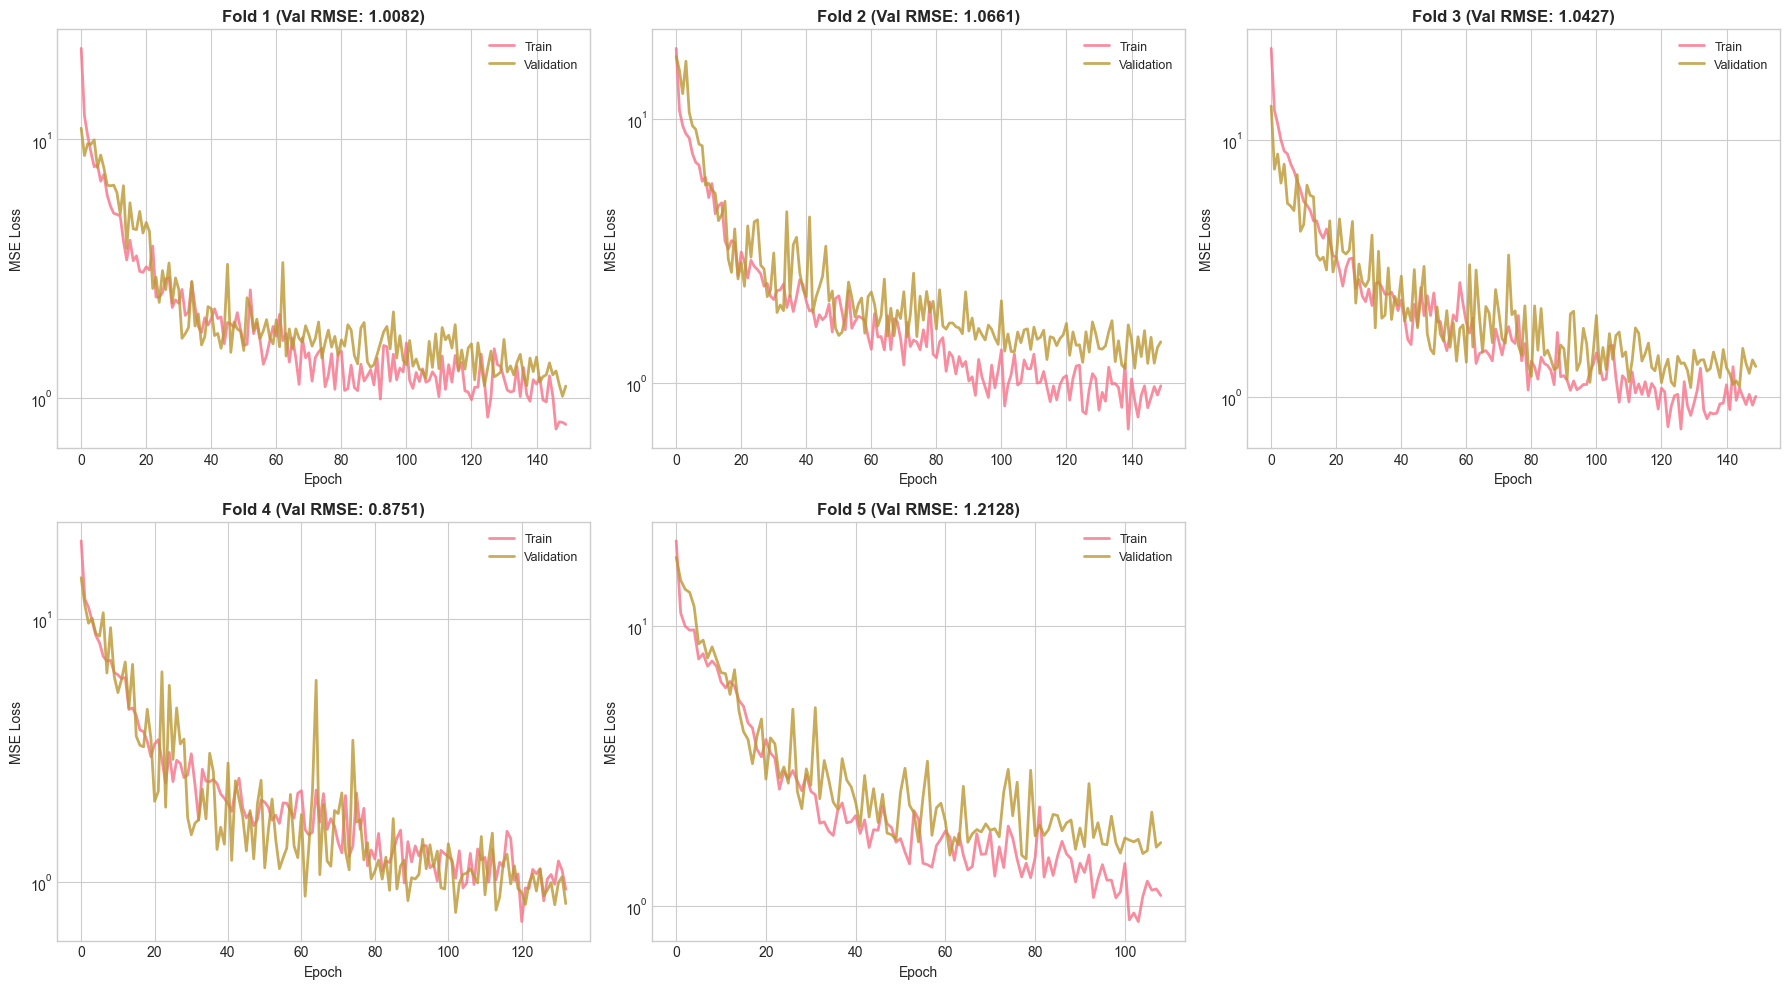


Using Fold 4 (best validation loss) for detailed visualization


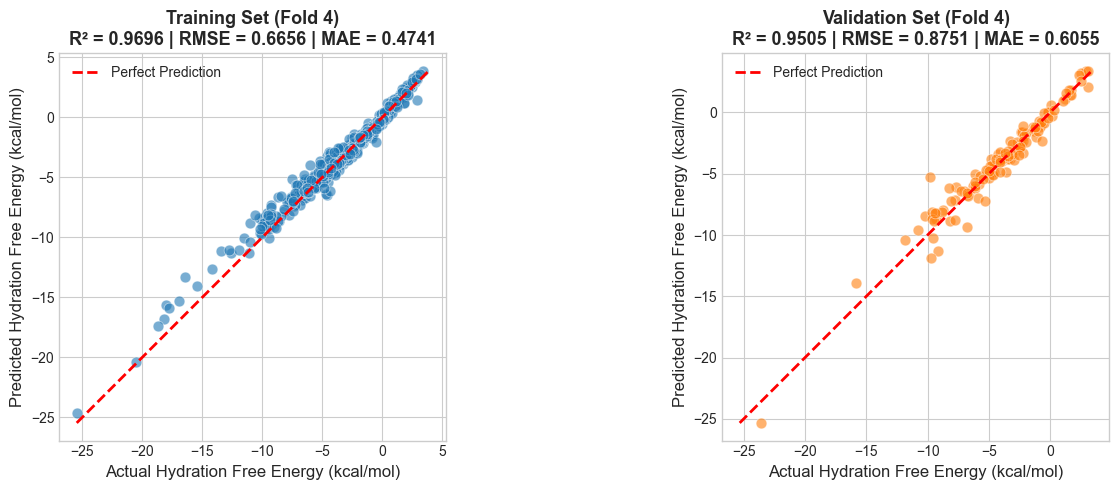

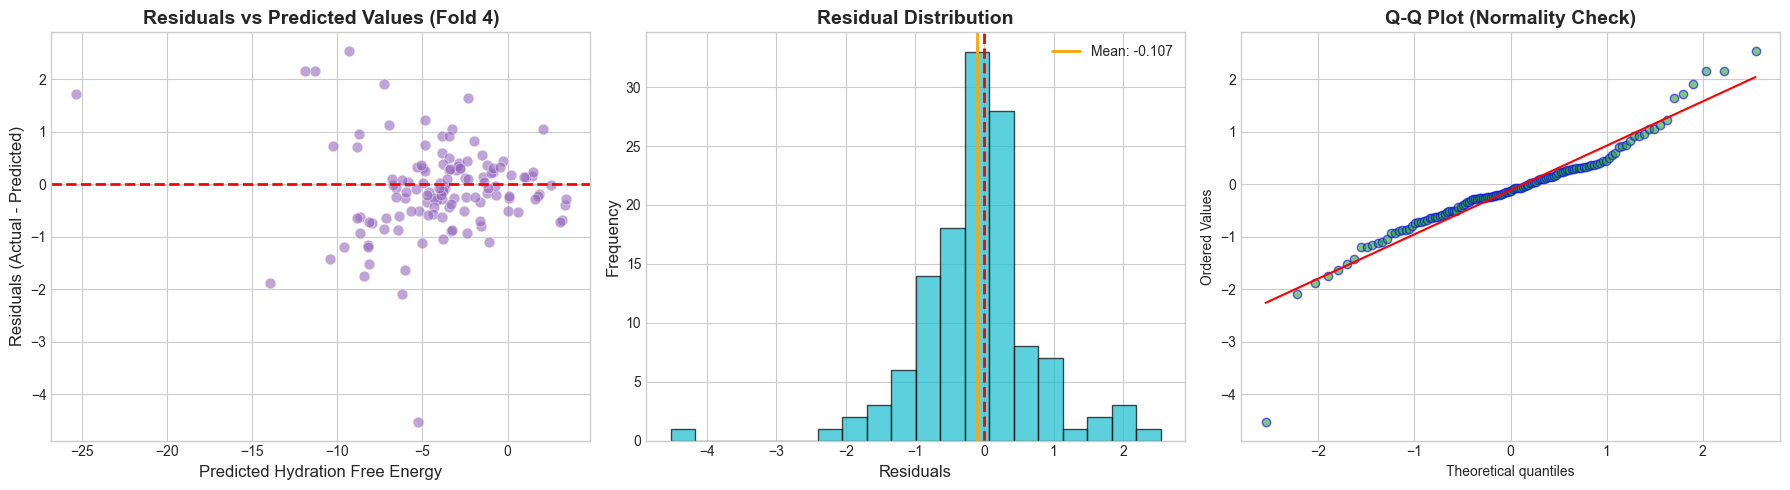


RESIDUAL STATISTICS (Validation Set - Fold 4)
Mean Residual: -0.1069
Std Residual:  0.8686
Min Residual:  -4.5237
Max Residual:  2.5415


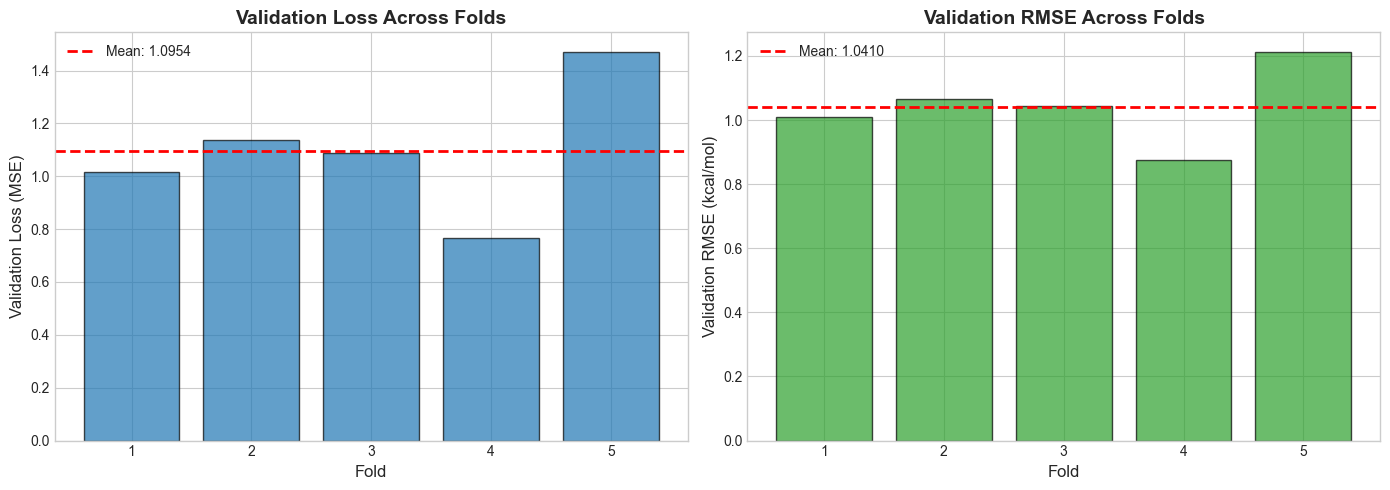

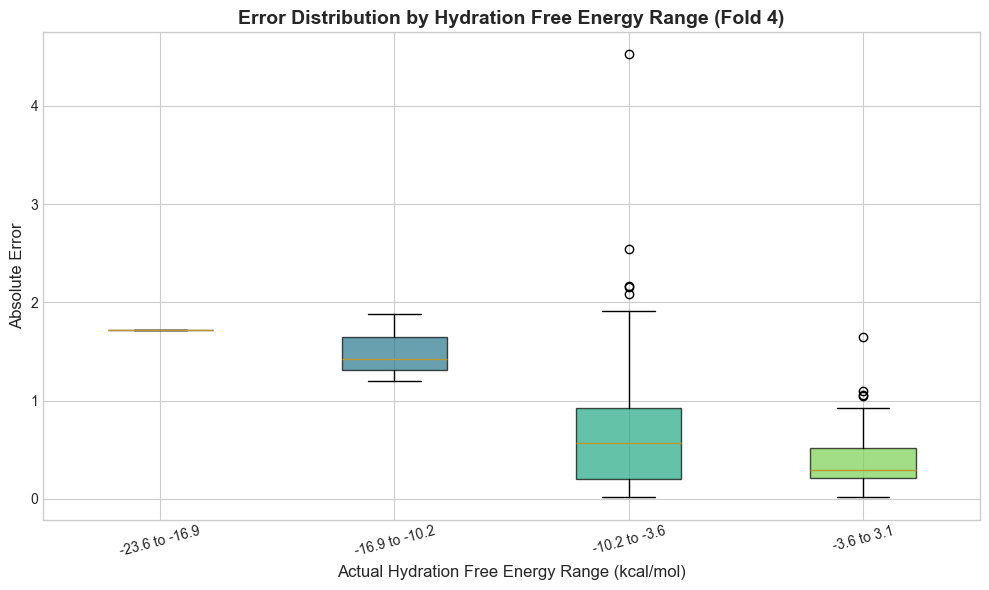


Computing t-SNE embeddings...


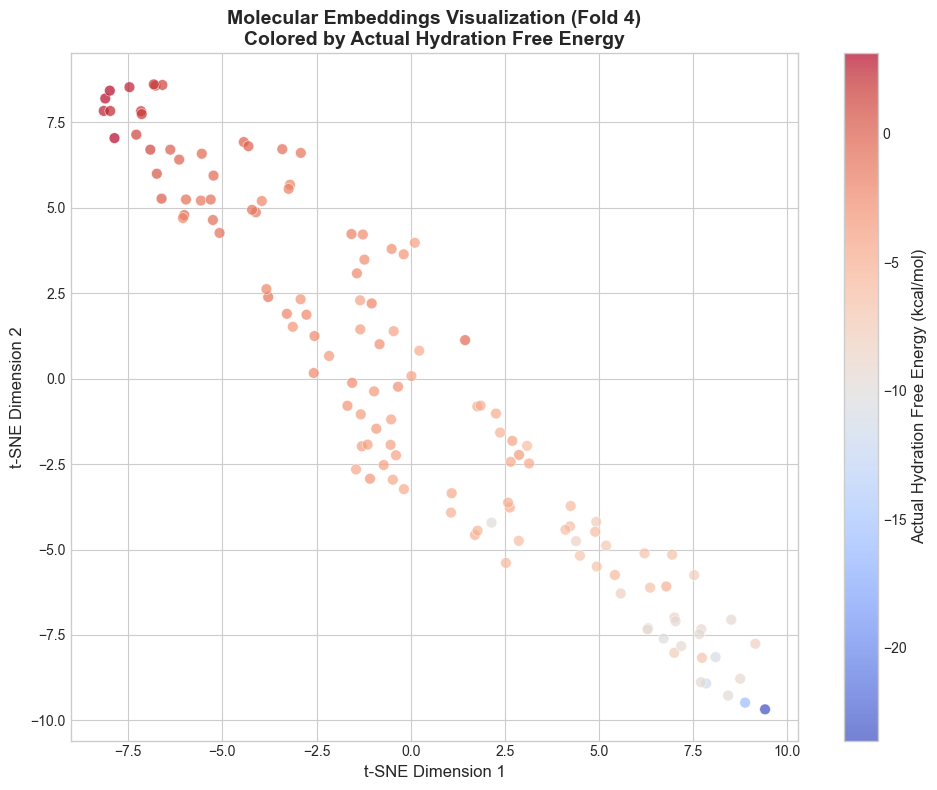


                  MODEL PERFORMANCE SUMMARY (Fold 4)                  

Dataset                MSE       RMSE        MAE         R²
-------------------------------------------------------
Train               0.4430     0.6656     0.4741     0.9696
Validation          0.7659     0.8751     0.6055     0.9505


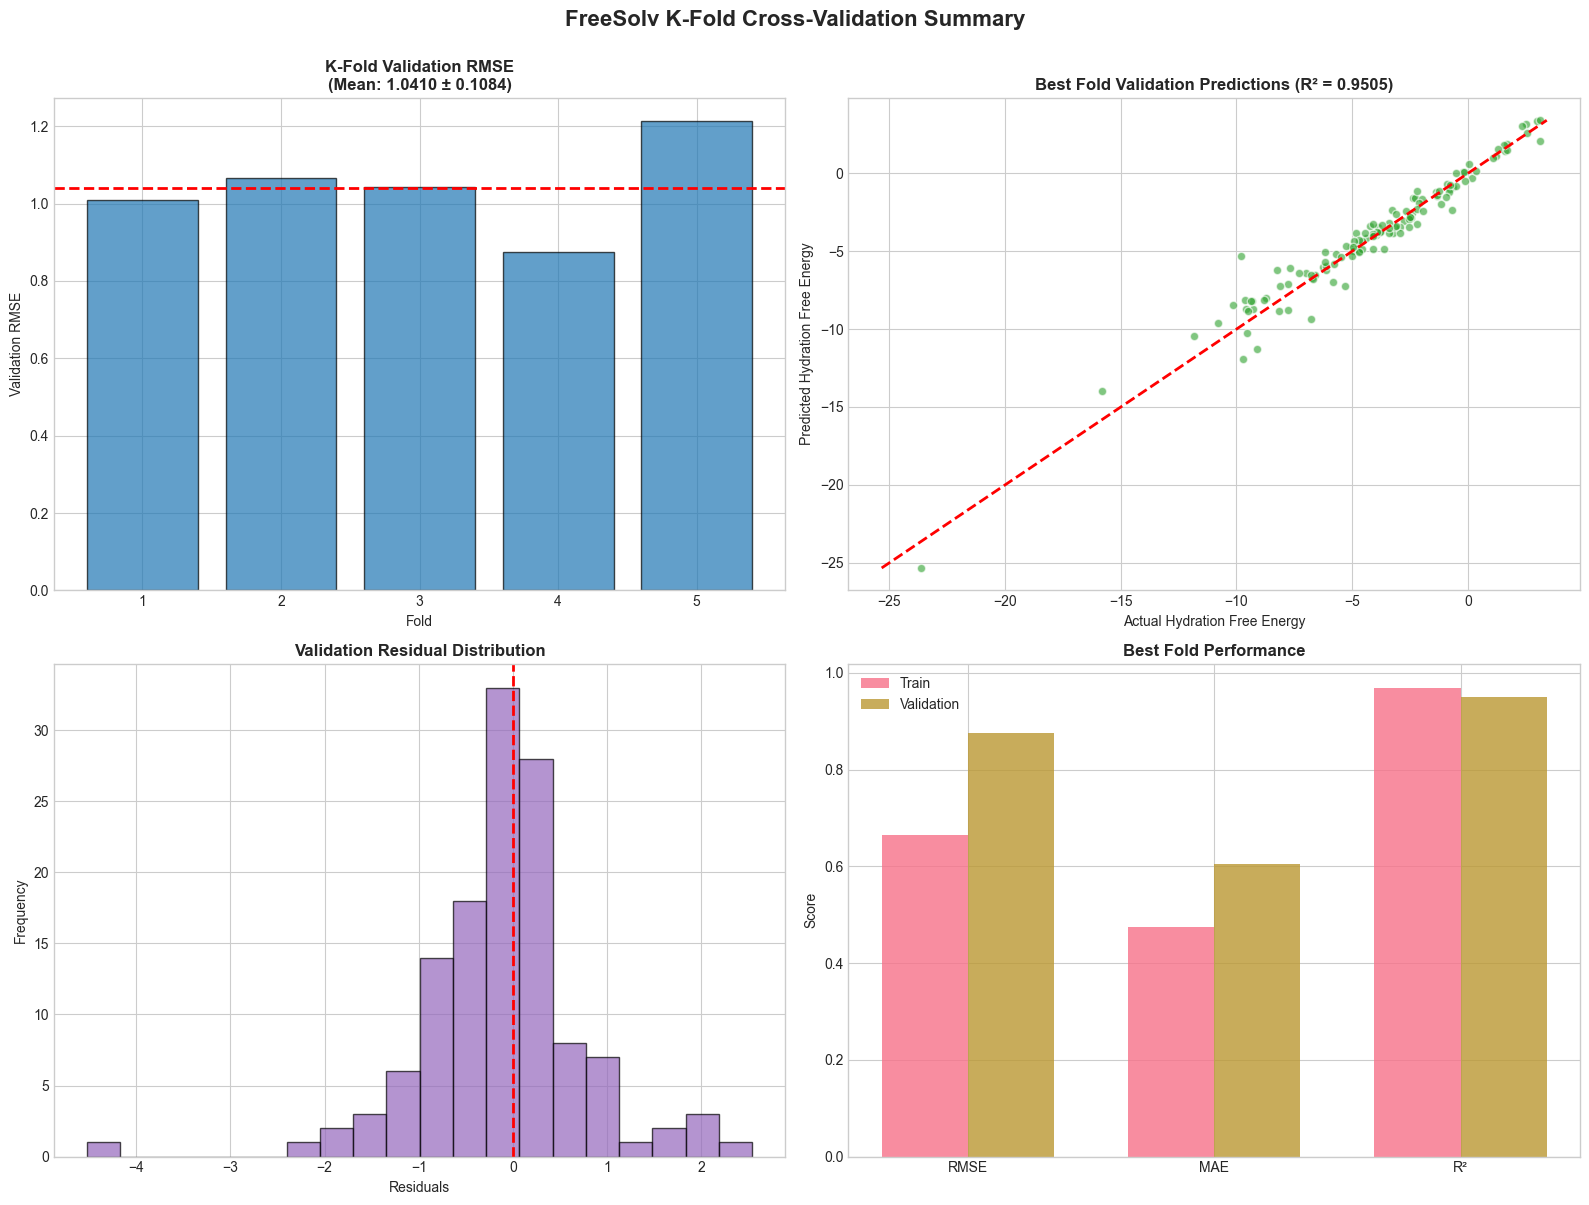


✅ All visualizations saved!
   - kfold_loss_curves.png
   - kfold_performance_comparison.png
   - predictions_vs_actual.png
   - residual_analysis.png
   - error_by_bins.png
   - tsne_embeddings.png
   - model_summary.png


In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")


def plot_kfold_loss_curves(fold_results):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for i, result in enumerate(fold_results):
        ax = axes[i]
        train_losses = result['train_losses']
        val_losses = result['val_losses']
        epochs = range(len(train_losses))
        
        ax.plot(epochs, train_losses, label='Train', alpha=0.8, linewidth=2)
        ax.plot(epochs, val_losses, label='Validation', alpha=0.8, linewidth=2)
        ax.set_xlabel('Epoch', fontsize=10)
        ax.set_ylabel('MSE Loss', fontsize=10)
        ax.set_title(f'Fold {result["fold"]} (Val RMSE: {result["val_rmse"]:.4f})', 
                     fontsize=12, fontweight='bold')
        ax.legend(fontsize=9)
        ax.set_yscale('log')
    
    # Hide the last subplot if we have 5 folds
    if len(fold_results) == 5:
        axes[5].axis('off')
    
    plt.tight_layout()
    plt.savefig('kfold_loss_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_kfold_loss_curves(fold_results)


def get_predictions(model, loader):
    model.eval()
    predictions = []
    actuals = []
    embeddings = []
    
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(DEVICE)
            pred, emb = model(batch.x.float(), batch.edge_index, batch.batch, batch.edge_attr.float())
            predictions.extend(pred.cpu().numpy().flatten())
            actuals.extend(batch.y.cpu().numpy().flatten())
            embeddings.append(emb.cpu().numpy())
    
    embeddings = np.vstack(embeddings)
    return np.array(predictions), np.array(actuals), embeddings


best_fold_idx = np.argmin([r['val_loss'] for r in fold_results])
best_fold = fold_results[best_fold_idx]

print(f"\nUsing Fold {best_fold['fold']} (best validation loss) for detailed visualization")

dataset_size = len(dataset)
fold_size = dataset_size // K_FOLDS
fold_num = best_fold['fold'] - 1

val_start = fold_num * fold_size
val_end = val_start + fold_size if fold_num < K_FOLDS - 1 else dataset_size

val_indices = list(range(val_start, val_end))
train_indices = list(range(0, val_start)) + list(range(val_end, dataset_size))

train_dataset_viz = dataset[train_indices]
val_dataset_viz = dataset[val_indices]

train_loader_viz = DataLoader(train_dataset_viz, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)
val_loader_viz = DataLoader(val_dataset_viz, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)

num_node_features = dataset.num_node_features
num_edge_features = dataset.num_edge_features

model_viz = MolecularGCN_EdgeNet(
    num_node_features=num_node_features,
    num_edge_features=num_edge_features
)
model_viz.load_state_dict(torch.load(f'best_model_fs_fold{best_fold["fold"]}.pt'))
model_viz.to(DEVICE)

train_preds, train_actuals, train_embeddings = get_predictions(model_viz, train_loader_viz)
val_preds, val_actuals, val_embeddings = get_predictions(model_viz, val_loader_viz)


def plot_predictions_vs_actual(train_preds, train_actuals, val_preds, val_actuals, fold_num):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    datasets = [
        (train_preds, train_actuals, f'Training Set (Fold {fold_num})', 'tab:blue'),
        (val_preds, val_actuals, f'Validation Set (Fold {fold_num})', 'tab:orange')
    ]
    
    for ax, (preds, actuals, title, color) in zip(axes, datasets):
        # Calculate metrics
        r2 = r2_score(actuals, preds)
        rmse = np.sqrt(np.mean((preds - actuals) ** 2))
        mae = mean_absolute_error(actuals, preds)
        
        # Scatter plot
        ax.scatter(actuals, preds, alpha=0.6, c=color, edgecolors='white', linewidth=0.5, s=60)
        
        # Perfect prediction line
        min_val = min(actuals.min(), preds.min())
        max_val = max(actuals.max(), preds.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
        
        # Labels and title
        ax.set_xlabel('Actual Hydration Free Energy (kcal/mol)', fontsize=12)
        ax.set_ylabel('Predicted Hydration Free Energy (kcal/mol)', fontsize=12)
        ax.set_title(f'{title}\nR² = {r2:.4f} | RMSE = {rmse:.4f} | MAE = {mae:.4f}', 
                     fontsize=13, fontweight='bold')
        ax.legend(loc='upper left', fontsize=10)
        
        # Equal aspect ratio
        ax.set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    plt.savefig('predictions_vs_actual.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_predictions_vs_actual(train_preds, train_actuals, val_preds, val_actuals, best_fold['fold'])


def plot_residual_analysis(val_preds, val_actuals, fold_num):
    residuals = val_actuals - val_preds
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Residuals vs Predicted
    ax1 = axes[0]
    ax1.scatter(val_preds, residuals, alpha=0.6, c='tab:purple', edgecolors='white', linewidth=0.5, s=60)
    ax1.axhline(y=0, color='red', linestyle='--', linewidth=2)
    ax1.set_xlabel('Predicted Hydration Free Energy', fontsize=12)
    ax1.set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
    ax1.set_title(f'Residuals vs Predicted Values (Fold {fold_num})', fontsize=14, fontweight='bold')
    
    # Plot 2: Residual Distribution
    ax2 = axes[1]
    ax2.hist(residuals, bins=20, color='tab:cyan', edgecolor='black', alpha=0.7)
    ax2.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax2.axvline(x=residuals.mean(), color='orange', linestyle='-', linewidth=2, label=f'Mean: {residuals.mean():.3f}')
    ax2.set_xlabel('Residuals', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title('Residual Distribution', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    
    # Plot 3: Q-Q Plot
    ax3 = axes[2]
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=ax3)
    ax3.set_title('Q-Q Plot (Normality Check)', fontsize=14, fontweight='bold')
    ax3.get_lines()[0].set_markerfacecolor('tab:green')
    ax3.get_lines()[0].set_alpha(0.6)
    
    plt.tight_layout()
    plt.savefig('residual_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print residual statistics
    print("\n" + "="*50)
    print(f"RESIDUAL STATISTICS (Validation Set - Fold {fold_num})")
    print("="*50)
    print(f"Mean Residual: {residuals.mean():.4f}")
    print(f"Std Residual:  {residuals.std():.4f}")
    print(f"Min Residual:  {residuals.min():.4f}")
    print(f"Max Residual:  {residuals.max():.4f}")

plot_residual_analysis(val_preds, val_actuals, best_fold['fold'])


def plot_kfold_performance_comparison(fold_results):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    folds = [r['fold'] for r in fold_results]
    val_losses = [r['val_loss'] for r in fold_results]
    val_rmses = [r['val_rmse'] for r in fold_results]
    
    # Plot 1: Validation Loss by Fold
    ax1 = axes[0]
    bars1 = ax1.bar(folds, val_losses, color='tab:blue', alpha=0.7, edgecolor='black')
    ax1.axhline(y=np.mean(val_losses), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {np.mean(val_losses):.4f}')
    ax1.set_xlabel('Fold', fontsize=12)
    ax1.set_ylabel('Validation Loss (MSE)', fontsize=12)
    ax1.set_title('Validation Loss Across Folds', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.set_xticks(folds)
    
    # Plot 2: Validation RMSE by Fold
    ax2 = axes[1]
    bars2 = ax2.bar(folds, val_rmses, color='tab:green', alpha=0.7, edgecolor='black')
    ax2.axhline(y=np.mean(val_rmses), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {np.mean(val_rmses):.4f}')
    ax2.set_xlabel('Fold', fontsize=12)
    ax2.set_ylabel('Validation RMSE (kcal/mol)', fontsize=12)
    ax2.set_title('Validation RMSE Across Folds', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.set_xticks(folds)
    
    plt.tight_layout()
    plt.savefig('kfold_performance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_kfold_performance_comparison(fold_results)


# ---  Error Distribution by Value Bins (Validation Set) ---
def plot_error_by_bins(val_preds, val_actuals, fold_num):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create bins based on actual values
    bins = np.linspace(val_actuals.min(), val_actuals.max(), 5)
    bin_labels = [f'{bins[i]:.1f} to {bins[i+1]:.1f}' for i in range(len(bins)-1)]
    
    # Calculate absolute errors
    abs_errors = np.abs(val_actuals - val_preds)
    
    # Assign each point to a bin
    bin_indices = np.digitize(val_actuals, bins) - 1
    bin_indices = np.clip(bin_indices, 0, len(bin_labels) - 1)
    
    # Group errors by bin
    binned_errors = [abs_errors[bin_indices == i] for i in range(len(bin_labels))]
    
    # Box plot
    bp = ax.boxplot(binned_errors, labels=bin_labels, patch_artist=True)
    
    # Color the boxes
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(bin_labels)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_xlabel('Actual Hydration Free Energy Range (kcal/mol)', fontsize=12)
    ax.set_ylabel('Absolute Error', fontsize=12)
    ax.set_title(f'Error Distribution by Hydration Free Energy Range (Fold {fold_num})', 
                 fontsize=14, fontweight='bold')
    plt.xticks(rotation=15)
    
    plt.tight_layout()
    plt.savefig('error_by_bins.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_error_by_bins(val_preds, val_actuals, best_fold['fold'])


# ---  Molecular Embeddings Visualization (t-SNE) ---
def plot_embeddings_tsne(val_embeddings, val_actuals, fold_num):
    from sklearn.manifold import TSNE
    
    print("\nComputing t-SNE embeddings...")
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(val_embeddings)-1))
    embeddings_2d = tsne.fit_transform(val_embeddings)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Scatter plot colored by actual hydration free energy
    scatter = ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                         c=val_actuals, cmap='coolwarm', 
                         alpha=0.7, s=60, edgecolors='white', linewidth=0.5)
    
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Actual Hydration Free Energy (kcal/mol)', fontsize=12)
    
    ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
    ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
    ax.set_title(f'Molecular Embeddings Visualization (Fold {fold_num})\nColored by Actual Hydration Free Energy', 
                 fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('tsne_embeddings.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_embeddings_tsne(val_embeddings, val_actuals, best_fold['fold'])


# --- Comprehensive Metrics Summary ---
def print_metrics_summary(train_preds, train_actuals, val_preds, val_actuals, fold_num):
    
    def compute_metrics(preds, actuals):
        mse = np.mean((preds - actuals) ** 2)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(actuals, preds)
        r2 = r2_score(actuals, preds)
        return mse, rmse, mae, r2
    
    print("\n" + "="*70)
    print(f"{'MODEL PERFORMANCE SUMMARY (Fold ' + str(fold_num) + ')':^70}")
    print("="*70)
    
    print(f"\n{'Dataset':<15} {'MSE':>10} {'RMSE':>10} {'MAE':>10} {'R²':>10}")
    print("-"*55)
    
    for name, preds, actuals in [('Train', train_preds, train_actuals),
                                   ('Validation', val_preds, val_actuals)]:
        mse, rmse, mae, r2 = compute_metrics(preds, actuals)
        print(f"{name:<15} {mse:>10.4f} {rmse:>10.4f} {mae:>10.4f} {r2:>10.4f}")
    
    print("="*70)

print_metrics_summary(train_preds, train_actuals, val_preds, val_actuals, best_fold['fold'])


# ---  Combined Summary Figure ---
def create_summary_figure(fold_results, train_preds, train_actuals, val_preds, val_actuals):
    
    fig = plt.figure(figsize=(16, 12))
    
    # 1. K-Fold RMSE comparison (top left)
    ax1 = fig.add_subplot(2, 2, 1)
    folds = [r['fold'] for r in fold_results]
    val_rmses = [r['val_rmse'] for r in fold_results]
    ax1.bar(folds, val_rmses, color='tab:blue', alpha=0.7, edgecolor='black')
    ax1.axhline(y=np.mean(val_rmses), color='red', linestyle='--', linewidth=2)
    ax1.set_xlabel('Fold')
    ax1.set_ylabel('Validation RMSE')
    ax1.set_title(f'K-Fold Validation RMSE\n(Mean: {np.mean(val_rmses):.4f} ± {np.std(val_rmses):.4f})', 
                  fontweight='bold')
    ax1.set_xticks(folds)
    
    # 2. Best fold predictions (top right)
    ax2 = fig.add_subplot(2, 2, 2)
    r2 = r2_score(val_actuals, val_preds)
    ax2.scatter(val_actuals, val_preds, alpha=0.6, c='tab:green', edgecolors='white')
    min_val, max_val = min(val_actuals.min(), val_preds.min()), max(val_actuals.max(), val_preds.max())
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    ax2.set_xlabel('Actual Hydration Free Energy')
    ax2.set_ylabel('Predicted Hydration Free Energy')
    ax2.set_title(f'Best Fold Validation Predictions (R² = {r2:.4f})', fontweight='bold')
    
    # 3. Residual histogram (bottom left)
    ax3 = fig.add_subplot(2, 2, 3)
    residuals = val_actuals - val_preds
    ax3.hist(residuals, bins=20, color='tab:purple', edgecolor='black', alpha=0.7)
    ax3.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax3.set_xlabel('Residuals')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Validation Residual Distribution', fontweight='bold')
    
    # 4. Metrics comparison (bottom right)
    ax4 = fig.add_subplot(2, 2, 4)
    
    metrics = ['RMSE', 'MAE', 'R²']
    train_metrics = [np.sqrt(np.mean((train_preds - train_actuals)**2)),
                     mean_absolute_error(train_actuals, train_preds),
                     r2_score(train_actuals, train_preds)]
    val_metrics = [np.sqrt(np.mean((val_preds - val_actuals)**2)),
                   mean_absolute_error(val_actuals, val_preds),
                   r2_score(val_actuals, val_preds)]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    ax4.bar(x - width/2, train_metrics, width, label='Train', alpha=0.8)
    ax4.bar(x + width/2, val_metrics, width, label='Validation', alpha=0.8)
    
    ax4.set_ylabel('Score')
    ax4.set_title('Best Fold Performance', fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(metrics)
    ax4.legend()
    
    plt.suptitle('FreeSolv K-Fold Cross-Validation Summary', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig('model_summary.png', dpi=300, bbox_inches='tight')
    plt.show()

create_summary_figure(fold_results, train_preds, train_actuals, val_preds, val_actuals)
